# Bone suppression(pix2pix)


## 前準備
### 主要パッケージのインポート

In [1]:
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from IPython.display import display
from logging import basicConfig, getLogger, INFO
basicConfig(level=INFO, format='%(asctime)s %(levelname)s :%(message)s')
logger = getLogger(__name__)

### データディレクトリの指定

In [2]:
DATA_ROOT = pathlib.Path('Data/Images/chest_xray')
INPUT_IMAGE_DIR = 'bone_enhancement'
TRUTH_IMAGE_DIR = 'bone_suppression'
CLASS_LABELS = ('lung')
IMAGE_EXT = '.png'

### 画像ファイルを基にpd.DataFrameを作成する

In [3]:
def create_dataset_df(data_root, input_dir, truth_dir, image_ext):
    dfs = []
    root = pathlib.Path(data_root)
    image_filenames = (root / pathlib.Path(input_dir)).glob('*' + image_ext)
    df = pd.DataFrame(image_filenames, columns=['input_path'])
    df['truth_path'] = df['input_path'].map(
        lambda p: root / pathlib.Path(truth_dir) / p.name)
    return df


df_dataset = create_dataset_df(DATA_ROOT, INPUT_IMAGE_DIR, TRUTH_IMAGE_DIR,
                               IMAGE_EXT)
display(df_dataset.head())

,input_path,truth_path
0,Data\Images\chest_xray\bone_enhancement\000.png,Data\Images\chest_xray\bone_suppression\000.png
1,Data\Images\chest_xray\bone_enhancement\001.png,Data\Images\chest_xray\bone_suppression\001.png
2,Data\Images\chest_xray\bone_enhancement\002.png,Data\Images\chest_xray\bone_suppression\002.png
3,Data\Images\chest_xray\bone_enhancement\003.png,Data\Images\chest_xray\bone_suppression\003.png
4,Data\Images\chest_xray\bone_enhancement\004.png,Data\Images\chest_xray\bone_suppression\004.png


### 画像を表示

<Figure size 720x360 with 0 Axes>

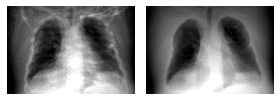

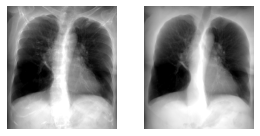

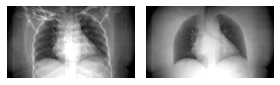

In [4]:
N_SAMPLES = 3
plt.figure(figsize=(10, 5))
for i, sample in enumerate(df_dataset.sample(n=N_SAMPLES).itertuples()):
    image = Image.open(sample.input_path)
    truth = Image.open(sample.truth_path)
    plt.figure(figsize=(4, 2))
    plt.subplot(1, 2, 1)
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(truth, cmap='gray')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

### Data augmentation

In [5]:
import functools
import tut_utils
INPUT_SHAPE = [1, 256, 256]
IMG_SHAPE = INPUT_SHAPE


def load_img(filepath):
    img = Image.open(filepath)
    img = img.resize(IMG_SHAPE[1:])
    return np.atleast_3d(img)


load_img2img_dataset = functools.partial(tut_utils.load_img2img_dataset,
                                         input_column='input_path',
                                         target_column='truth_path')

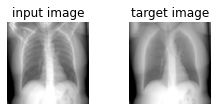

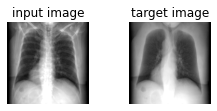

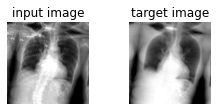

In [6]:
import albumentations as A
from tut_utils import AugmentedDataset
from torch.utils.data import DataLoader

album_transform = A.Compose([
    A.RandomBrightnessContrast(brightness_limit=.1, contrast_limit=.1, p=.5),
    A.HorizontalFlip(p=.25),
    A.ShiftScaleRotate(shift_limit=0, scale_limit=.2, rotate_limit=10, p=.8)
],
                            additional_targets={'image0': 'image'})


def random_transform(x, y):
    x = (x / 255).astype(np.float32)
    y = (y / 255).astype(np.float32)
    tfed = album_transform(image=x, image0=y)
    x, y = tfed['image'], tfed['image0']
    x, y = x.transpose(2, 0, 1), y.transpose(2, 0, 1)
    return x.astype(np.float32), y.astype(np.float32)


N_TEST = 3


def test_augmentation(df_dataset):
    df_train = df_dataset.iloc[:N_TEST]
    train_data, train_labels = load_img2img_dataset(df_train, load_img)
    dataset = AugmentedDataset(train_data, train_labels, random_transform)

    loader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=0)
    for i, data in enumerate(loader):
        plt.figure(figsize=(4, 1.5))
        plt.subplot(1, 2, 1)
        plt.imshow(data[0].squeeze().numpy(), cmap='gray')
        plt.title('input image')
        plt.axis('off')
        plt.subplot(1, 2, 2)
        plt.imshow(data[1].squeeze().numpy(), cmap='gray')
        plt.title('target image')
        plt.axis('off')
        plt.show()


test_augmentation(df_dataset)

## モデル作成

### Generator model
UNet ver.と同じものを使う

In [7]:
OUTPUT_CHANNELS = 1
UNET_DEPTH = 6
IN_CHS = 1
OUT_CHS = 1
INI_CHS = 16
from tut_models import UNet
from torchsummary import summary
summary(UNet(IN_CHS, OUT_CHS, UNET_DEPTH, ini_chs=INI_CHS),
        INPUT_SHAPE,
        verbose=0,
        device='cpu')

Layer (type:depth-idx)                   Output Shape              Param #
├─ModuleList: 1                          []                        --
|    └─Encoder: 2-1                      [-1, 32, 256, 256]        --
|    |    └─Sequential: 3-1              [-1, 32, 256, 256]        4,896
├─ModuleList: 1                          []                        --
|    └─MaxPool2d: 2-2                    [-1, 32, 128, 128]        --
├─ModuleList: 1                          []                        --
|    └─Encoder: 2-3                      [-1, 64, 128, 128]        --
|    |    └─Sequential: 3-2              [-1, 64, 128, 128]        27,936
├─ModuleList: 1                          []                        --
|    └─MaxPool2d: 2-4                    [-1, 64, 64, 64]          --
├─ModuleList: 1                          []                        --
|    └─Encoder: 2-5                      [-1, 128, 64, 64]         --
|    |    └─Sequential: 3-3              [-1, 128, 64, 64]         111,168
├─M

### Discriminator model

In [8]:
import torch
import torch.nn as nn
import tut_models


class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            tut_models.ConvBNReLU(2, 16, 3, 0, leaky=True),
            tut_models.ConvBNReLU(16, 32, 3, 0, leaky=True), nn.MaxPool2d(2),
            tut_models.ConvBNReLU(32, 32, 3, 0, leaky=True),
            tut_models.ConvBNReLU(32, 64, 3, 0, leaky=True), nn.MaxPool2d(2),
            tut_models.ConvBNReLU(64, 64, 3, 0, leaky=True),
            tut_models.ConvBNReLU(64, 128, 3, 0, leaky=True), nn.MaxPool2d(2),
            tut_models.ConvBNReLU(128, 128, 3, 0, leaky=True),
            tut_models.ConvBNReLU(128, 256, 3, 0, leaky=True), nn.MaxPool2d(2),
            nn.Conv2d(256, 1, kernel_size=3, padding=0))

    def forward(self, input_image, target_image):
        cat = torch.cat([input_image, target_image], dim=1)
        return self.model(cat)


summary(Discriminator(), [INPUT_SHAPE, INPUT_SHAPE], verbose=0, device='cpu')

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1, 10, 10]           --
|    └─ConvBNReLU: 2-1                   [-1, 16, 254, 254]        --
|    |    └─Sequential: 3-1              [-1, 16, 254, 254]        336
|    └─ConvBNReLU: 2-2                   [-1, 32, 252, 252]        --
|    |    └─Sequential: 3-2              [-1, 32, 252, 252]        4,704
|    └─MaxPool2d: 2-3                    [-1, 32, 126, 126]        --
|    └─ConvBNReLU: 2-4                   [-1, 32, 124, 124]        --
|    |    └─Sequential: 3-3              [-1, 32, 124, 124]        9,312
|    └─ConvBNReLU: 2-5                   [-1, 64, 122, 122]        --
|    |    └─Sequential: 3-4              [-1, 64, 122, 122]        18,624
|    └─MaxPool2d: 2-6                    [-1, 64, 61, 61]          --
|    └─ConvBNReLU: 2-7                   [-1, 64, 59, 59]          --
|    |    └─Sequential: 3-5              [-1, 64, 59, 59]          37,056


## 学習
### ホールドアウト

In [9]:
from sklearn.model_selection import KFold
N_SPLITS = 5
SEED = 0
kfold = KFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)
train_index, test_index = next(kfold.split(df_dataset['input_path']))

df_train = df_dataset.iloc[train_index]
df_test = df_dataset.iloc[test_index]

### lit model

In [10]:
import pytorch_lightning as pl
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt


class LitPix2Pix(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.generator = UNet(IN_CHS, OUT_CHS, UNET_DEPTH, ini_chs=INI_CHS)
        self.discriminator = Discriminator()
        self.pix_weight = 100  # weight for pixelwise loss

    def forward(self, x):
        return self.generator(x)

    def adversarial_loss(self, y_hat, y):
        return F.binary_cross_entropy_with_logits(y_hat, y)

    def pixelwise_loss(self, input_data, target_data):
        return F.l1_loss(input_data, target_data)

    def training_step(self, batch, batch_idx, optimizer_idx):
        input_imgs, target_imgs = batch
        self.input, self.target = input_imgs, target_imgs

        if optimizer_idx == 0:  # train generator
            g_out = self(input_imgs)
            self.g_out = g_out

            d_out = self.discriminator(input_imgs, self.g_out)

            # adversarial loss
            g_loss_adv = self.adversarial_loss(d_out, torch.ones_like(d_out))
            # pixelwise loss
            g_loss_pix = self.pixelwise_loss(g_out, target_imgs)
            g_loss = g_loss_adv + (self.pix_weight * g_loss_pix)
            loss = g_loss

        if optimizer_idx == 1:  # train discriminator
            g_out = self(input_imgs)
            self.g_out = g_out
            self.g_out.detach()

            # target_imgs is real
            d_out = self.discriminator(input_imgs, target_imgs)
            d_loss_real = self.adversarial_loss(d_out, torch.ones_like(d_out))

            # g_out is fake
            d_out = self.discriminator(input_imgs, self.g_out)
            d_loss_fake = self.adversarial_loss(d_out, torch.zeros_like(d_out))

            # discriminator loss is the average of these
            d_loss = .5 * (d_loss_real + d_loss_fake)
            loss = d_loss

        self.log('train_loss', loss)
        return loss

    def configure_optimizers(self):
        opt_g = optim.Adam(self.generator.parameters(), lr=2e-4)
        opt_d = optim.Adam(self.discriminator.parameters(), lr=2e-4)
        return [opt_g, opt_d], []

    def on_epoch_end(self):
        if self.current_epoch % 4 != 0:
            return
        for i, img in enumerate([self.input[0], self.target[0],
                                 self.g_out[0]]):
            img = img.cpu().numpy().squeeze()
            plt.subplot(1, 3, i + 1)
            plt.imshow(img, cmap='gray')
            plt.axis('off')
        plt.show()

### Fit

100%|██████████| 228/228 [00:00<00:00, 289.24it/s]
GPU available: True, used: True
2021-03-31 14:11:13,332 INFO :GPU available: True, used: True
TPU available: None, using: 0 TPU cores
2021-03-31 14:11:13,333 INFO :TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
2021-03-31 14:11:13,334 INFO :LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type          | Params
------------------------------------------------
0 | generator     | UNet          | 34.6 M
1 | discriminator | Discriminator | 589 K 
------------------------------------------------
35.2 M    Trainable params
0         Non-trainable params
35.2 M    Total params
2021-03-31 14:11:14,566 INFO :
  | Name          | Type          | Params
------------------------------------------------
0 | generator     | UNet          | 34.6 M
1 | discriminator | Discriminator | 589 K 
------------------------------------------------
35.2 M    Trainable params
0         Non-trainable params
35.2 M

Training: 0it [00:00, ?it/s]

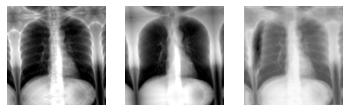

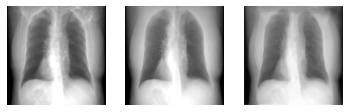

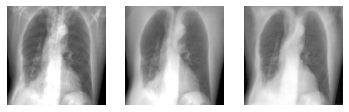

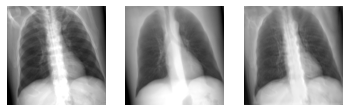

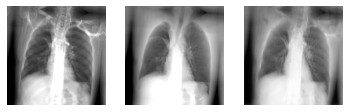

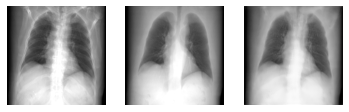

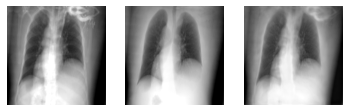

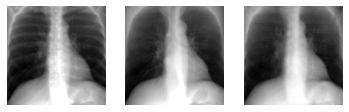

2021-03-31 14:19:24,404 INFO :Finish training


In [11]:
import os
EPOCHS = 32
BATCH_SIZE = 2
NUM_WORKERS = 0 if os.name == 'nt' else 2
gpus = 1 if torch.cuda.is_available() else 0
# gpus = 0

train_data, train_labels = load_img2img_dataset(df_train,
                                                load_img,
                                                verbose=True)
dataset = AugmentedDataset(train_data, train_labels, random_transform)
trainloader = DataLoader(dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=True,
                         num_workers=NUM_WORKERS)

model = LitPix2Pix()
trainer = pl.Trainer(gpus=gpus, max_epochs=EPOCHS)

trainer.fit(model, trainloader)
logger.info('Finish training')

## 評価
目視で評価する

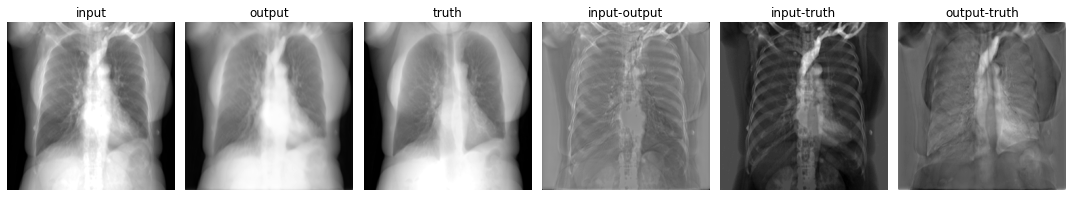

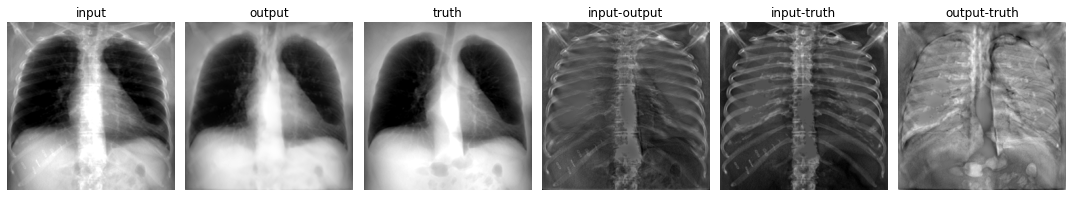

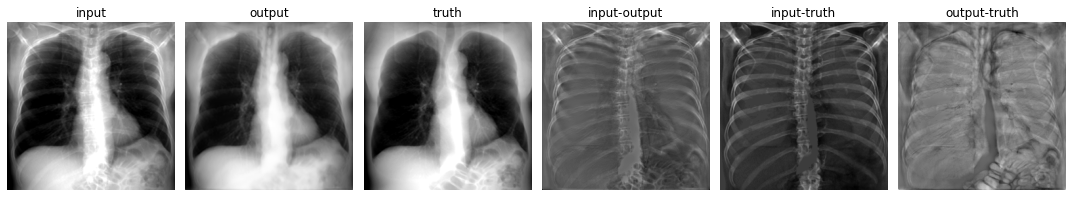

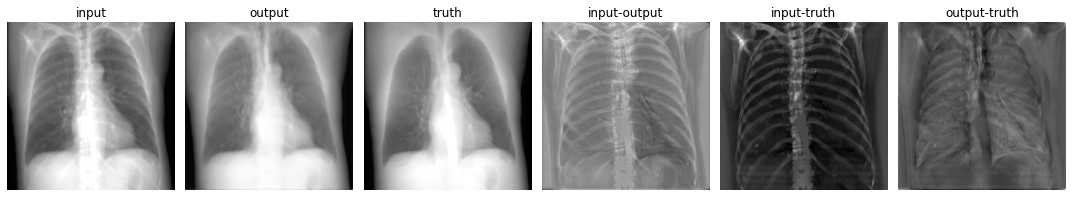

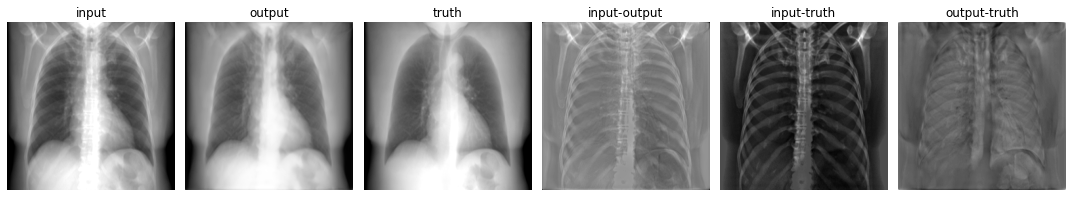

In [12]:
from sklearn import metrics


def show_images_in_a_row(images, titles, figsize=(15, 5)):
    assert len(images) == len(titles), 'Invalid size of arguments'
    plt.figure(figsize=figsize)
    for i, (image, title) in enumerate(zip(images, titles), 1):
        plt.subplot(1, len(images), i)
        plt.imshow(image, cmap='gray')
        plt.title(title)
        plt.axis('off')
    plt.tight_layout()
    plt.show()


model.eval()
model.freeze()

scores = []
for i, index in enumerate(test_index):
    image = load_img(df_dataset.iloc[index].input_path)
    truth = load_img(df_dataset.iloc[index].truth_path)
    truth = np.array(truth) / 255
    truth = truth.squeeze()

    image = np.atleast_3d(image)
    image = np.array(image) / 255
    image = image.transpose(2, 0, 1)
    pred = model(torch.FloatTensor(image[np.newaxis])).squeeze().cpu().numpy()
    image = image.squeeze()
    if i < 5:
        show_images_in_a_row(*zip((image, 'input'), (pred, 'output'), (
            truth, 'truth'), (image - pred, 'input-output'), (
                image - truth, 'input-truth'), (pred - truth, 'output-truth')))
    else:
        break

## 保存
Generator(UNet)を保存する

In [13]:
torch.save(model.generator.state_dict(), 'pix2pix_generator.ckpt')